# EMMA Analysis
This notebook analyzes the statistical characteristics of the EMMA labels collected in 2023

In [ ]:
import pandas as pd
from conf import DATA_DIR, RECBOLE_DATA_DIR, gems_9
import matplotlib.pyplot as plt

from sklearn import mixture
import numpy as np
import scipy.stats as stats


In [2]:
emma_final = pd.read_csv(DATA_DIR + 'EMMA_total_wide.csv')

New songs were annotated using GEMS-9

In [3]:
emma_new_final = emma_final[emma_final.gems_version == 'gems-9']

Old songs were annotated using GEMS-45

In [4]:
emma_old_final = emma_final[emma_final.gems_version == 'gems-45']

In [6]:
emma_to_compare = emma_new_final.copy()
emma_to_compare = emma_to_compare[['song_code'] + gems_9 + ['title', 'artist', 'genre']]

# Normalize to 1
row_sums = emma_new_final[gems_9].sum(axis=1)
emma_to_compare[gems_9] = emma_new_final[gems_9] / row_sums[:, np.newaxis]

emma_to_compare.to_csv(DATA_DIR + 'emma_to_compare.csv', index=False)

/tmp/ipykernel_39637/2675853844.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  emma_to_compare[gems_9] = emma_new_final[gems_9] / row_sums[:, np.newaxis]


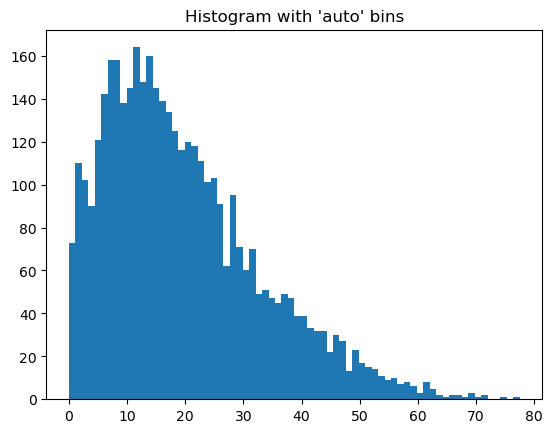

In [9]:
_ = plt.hist(emma_new_final[gems_9].to_numpy().flatten(), bins=70)  # arguments are passed to np.histogram

plt.title("Histogram with 'auto' bins")

plt.show()

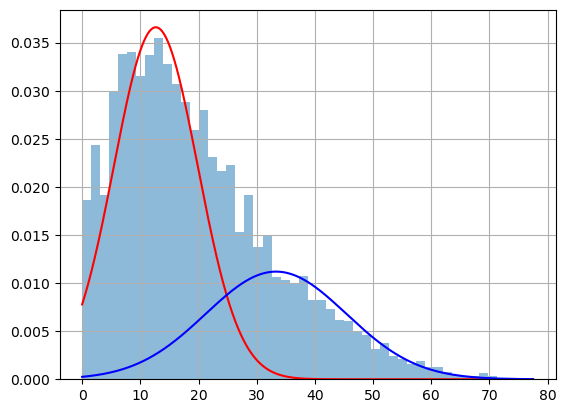

In [10]:
f = emma_new_final[gems_9].to_numpy().flatten().reshape(-1, 1)

g = mixture.GaussianMixture(n_components=2, covariance_type='full')
g.fit(f)
weights = g.weights_
means = g.means_
covars = g.covariances_

plt.hist(f, bins=50, histtype='bar', density=True, alpha=0.5)

f_axis = f.copy().ravel()
f_axis.sort()
plt.plot(f_axis, weights[0] * stats.norm.pdf(f_axis, means[0], np.sqrt(covars[0])).ravel(), c='red')
plt.plot(f_axis, weights[1] * stats.norm.pdf(f_axis, means[1], np.sqrt(covars[1])).ravel(), c='blue')

plt.rcParams['agg.path.chunksize'] = 10000

plt.grid()
plt.show()

In [12]:
# binarize by
# setting the same sparsity as in the tags

In [14]:
# this value is such that the sparsity of the binarized EMMA corresponds to the sparsity 
# of the binarized tags. Notice that it also roughly corresponds to the separation of the two gaussians in the GMM.
threshold = np.percentile(f, 65.14594064262939)
threshold

22.600148888286434

In [16]:
emma_bin_to_compare = emma_to_compare.copy()
emma_bin_to_compare[gems_9] = (emma_new_final[gems_9] > (threshold)) * 1.

In [18]:
emma_bin_to_compare.to_csv(DATA_DIR + 'emma_bin_to_compare.csv', index=False)

In [21]:
f = emma_bin_to_compare[gems_9]
f.sum() / len(f)

wond    0.298013
tran    0.183223
tend    0.364238
nost    0.538631
peac    0.408389
joya    0.587196
ener    0.459161
sadn    0.136865
tens    0.161148
dtype: float64

In [25]:
emma_bin_to_compare.columns = ['item_id:token'] + list(emma_bin_to_compare.columns[1:])
emma_bin_to_compare = emma_bin_to_compare[list(emma_bin_to_compare.columns[0:10])]

In [26]:
import numpy as np
index_to_gems_9 = {index: gems for index, gems in enumerate(gems_9)}
indices = [list(np.nonzero(x)[0].astype(int)) for x in emma_bin_to_compare[gems_9].to_numpy()]
emma_bin_to_compare['emotions:token_seq'] = indices
emma_for_recbole = emma_bin_to_compare[['item_id:token', 'emotions:token_seq']]
emma_for_recbole

/tmp/ipykernel_39637/1284577704.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emma_bin_to_compare['emotions:token_seq'] = indices


,item_id:token,emotions:token_seq
364,04q3VppIQEET5rzy,"[5, 6]"
365,07xF9Q0K1t3ist7K,"[0, 5, 6]"
366,08QtcDK0rtDFogFP,"[3, 6]"
367,0aXjQyzzLGf1xxdI,[4]
368,0d32mc0rFIgiPh0B,"[5, 6]"
...,...,...
812,zsDz17XVFUFYh4y7,"[0, 2, 3, 4]"
813,ZSnDQ7mhvjJLx9IG,[]
814,zTyH0fZwZ8ytmKuF,"[2, 3, 4, 5, 6, 7]"
815,ZVjUg4rlqeq2zk7C,"[4, 5]"


In [27]:
emma_for_recbole.to_csv(f'{RECBOLE_DATA_DIR}/emma.item', sep='\t', index=None)